In [1]:
from utils import sanitize
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions, AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole

from rxnmapper import RXNMapper
rxnmapper = RXNMapper()

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expec

In [2]:
def make_rxn_sma(rxn_entry):
    '''
    Convert our standard rxn json
    entry into a reaction smarts
    '''
    reactants = sanitize(list(rxn_entry[0].values()))
    products = sanitize(list(rxn_entry[1].values()))
    sma = ".".join(reactants) + ">>" + ".".join(products)
    return sma

def atom_map(rxn_sma):
    return rxnmapper.get_attention_guided_atom_maps([rxn_sma])[0]['mapped_rxn']



def peri_rxn_ctr_mcs_v0(rxn_ctr_sma, mol1, mol2):
    pass

In [8]:
# Take reaction substrates

pred_rxn_sma = 'O=C(O)CCC(CC(=O)O)C(=O)O.\
                NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1\
                >>O=C(O)C=C(CCC(=O)O)C(=O)O.\
                NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1'

known_rxn_entry = [{'(2R)-2-methylbutanedioic acid:0': 'CC(CC(=O)O)C(=O)O',
                    'NAD+:0': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'},
                    {'NADH:0': 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
                    'citraconic acid:0': 'CC(=CC(=O)O)C(=O)O'}]

known_rxn_sma = make_rxn_sma(known_rxn_entry)

# Atom map
m_pred = atom_map(pred_rxn_sma)
m_known = atom_map(known_rxn_sma)

# Construct reaction objects
pred_rxn = AllChem.ReactionFromSmarts(m_pred, useSmiles=True)
known_rxn = AllChem.ReactionFromSmarts(m_known, useSmiles=True)

# Get reaction center
pred_rxn.Initialize()
pred_ratoms = pred_rxn.GetReactingAtoms() # Tuple of tuples. Ea subtuple atom idxs for that reactant

# Compute MCS seeded by reaction center

In [87]:
def get_sub_mol(mol, ratoms):
    '''
    Given mol object and tuple
    of atom indices returns mol 
    of the part of the mol with
    atoms at those indices incl bonds if applicable
    '''
    sub_mol = Chem.RWMol() # New mol object to be edited
    old2new = {}
    # Add atoms, set formal charge
    for i, elt in enumerate(ratoms):
        atom = mol.GetAtomWithIdx(elt)
        fc = atom.GetFormalCharge()
        anum = atom.GetAtomicNum()
        old2new[elt] = i
        sub_mol.AddAtom(Chem.Atom(anum))
        sub_mol.GetAtomWithIdx(i).SetFormalCharge(fc)

    # Add bonds
    for a1 in ratoms:
        for a2 in ratoms:
            if a1 < a2:
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is not None:
                    b_type = bond.GetBondType() # Single, double, ...
                    sub_mol.AddBond(old2new[a1], old2new[a2], b_type)

    sub_mol = Chem.Mol(sub_mol)
    Chem.SanitizeMol(sub_mol) # Trust in Greg Landrum
    return sub_mol

In [38]:
'''
To do: 
    1. Get reaction json entries
    2. Make rxn sma (maintain order & copy of non-atom-mapped smiles / smarts)
    3. Get reacting atoms
    4. Match predicted and known reaction reactants by rxn ctr 
        (Compare smiles/smarts strings? How go from atom idxs returned by getreactingatoms
        to smiles for substructure search? If I can do this, then I can )
    5. For all pairs and all permutations of rxn ctr atom map idxs
        - renumber known reaction center according to pred atom map idxs
        - Set isotopes
        - FindMCS
        - Save largest MCS



    Does canonical smiles guarantee order invariance? If so
    can re-number atom mapping of rxn ctr left to right. Remove
    atom mapping from non rxn ctr? May not be necessary...
'''

'\nTo do: \n    1. Get reaction json entries\n    2. Make rxn sma (maintain order & copy of non-atom-mapped smiles / smarts)\n    3. Get reacting atoms\n    4. Filter out cofactors\n    5. \n'

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


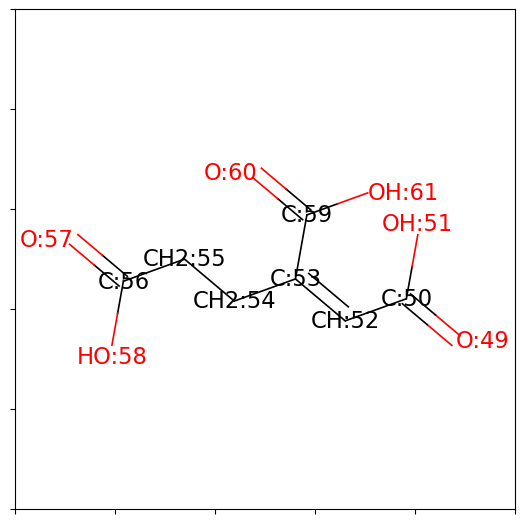

In [40]:
prod = pred_rxn.GetProductTemplate(1)
img = Draw.MolToMPL(prod, size=(200,200))
img.show()

In [41]:
atom = prod.GetAtomWithIdx(10)
print(atom.GetAtomMapNum())
atom.SetIsotope(atom.GetAtomMapNum())
print(atom.GetIsotope())
atom.GetAtomicNum()


59
59


6

In [42]:
pred_rxn.GetReactantTemplate(0).GetAtomWithIdx(0).GetAtomMapNum()

1

In [43]:
known_rxn.Initialize()
known_rxn.GetReactingAtoms()

((1, 2), (3, 4, 5, 41, 42, 43))

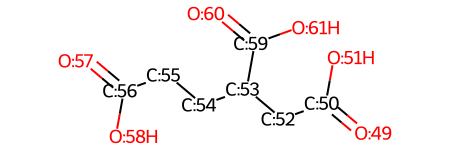

In [44]:
pred_rxn.GetReactantTemplate(1)

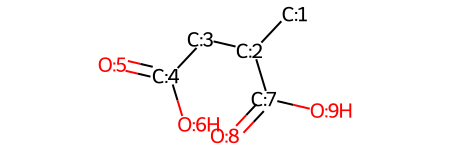

In [45]:
known_rxn.GetReactantTemplate(0)

# common atoms / bonds: 9 / 8


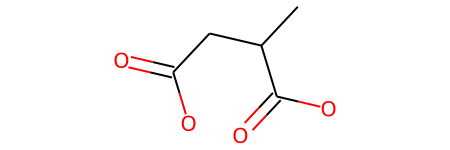

In [46]:
pred_reactant = pred_rxn.GetReactantTemplate(1)
known_reactant = known_rxn.GetReactantTemplate(0)
mols = [pred_reactant, known_reactant]
res = rdFMCS.FindMCS(mols, bondCompare=rdFMCS.BondCompare.CompareOrderExact, matchValences=True)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
Chem.MolFromSmarts(res.smartsString)

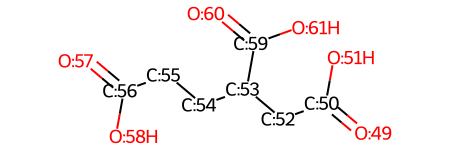

In [47]:
pred_rxn.GetReactantTemplate(1)

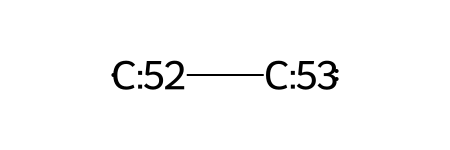

In [48]:
pridx = pred_rxn.GetReactingAtoms()[1]
pred_mol = pred_rxn.GetReactantTemplate(1)

Chem.MolFromSmiles(Chem.MolFragmentToSmiles(pred_mol, pridx))

In [49]:
pridx = pred_rxn.GetReactingAtoms()[1]
pred_mol = pred_rxn.GetProductTemplate(1)
pred_ss = Chem.MolFragmentToSmarts(pred_mol, pridx)
print(pred_ss)

kridx = known_rxn.GetReactingAtoms()[0]
known_mol = known_rxn.GetProductTemplate(0)
known_ss = Chem.MolFragmentToSmarts(known_mol, kridx)

print(known_ss)

[#6H:52]=[#6:53]
[#6:2]=[#6H:3]


# common atoms / bonds: 9 / 8


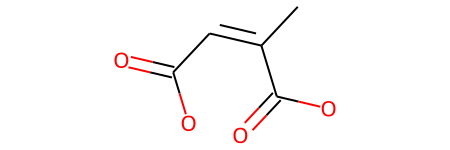

In [50]:
pred_product = pred_rxn.GetProductTemplate(1)
known_product = known_rxn.GetProductTemplate(0)
mols = [pred_product, known_product]
res = rdFMCS.FindMCS(mols, seedSmarts=known_ss)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
Chem.MolFromSmarts(res.smartsString)

In [51]:
pridx = pred_rxn.GetReactingAtoms()[1]
pred_mol = pred_rxn.GetReactantTemplate(1)
pred_ss = Chem.MolFragmentToSmarts(pred_mol, pridx)
print(pred_ss)

kridx = known_rxn.GetReactingAtoms()[0]
known_mol = known_rxn.GetReactantTemplate(0)
known_ss = Chem.MolFragmentToSmarts(known_mol, kridx)

print(known_ss)

[#6H2:52]-[#6H:53]
[#6H:2]-[#6H2:3]


# common atoms / bonds: 9 / 8


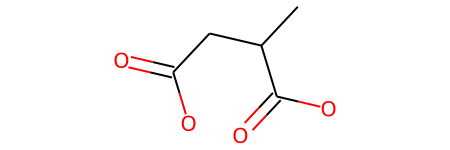

In [52]:
pred_reactant = pred_rxn.GetReactantTemplate(1)
known_reactant = known_rxn.GetReactantTemplate(0)
mols = [pred_reactant, known_reactant]
res = rdFMCS.FindMCS(mols, seedSmarts=known_ss)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
Chem.MolFromSmarts(res.smartsString)

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


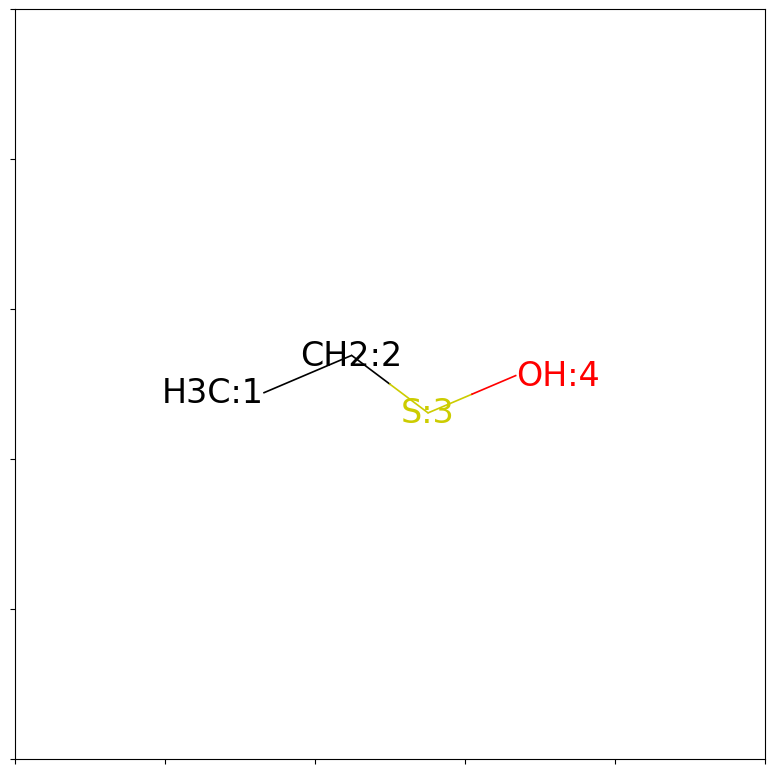

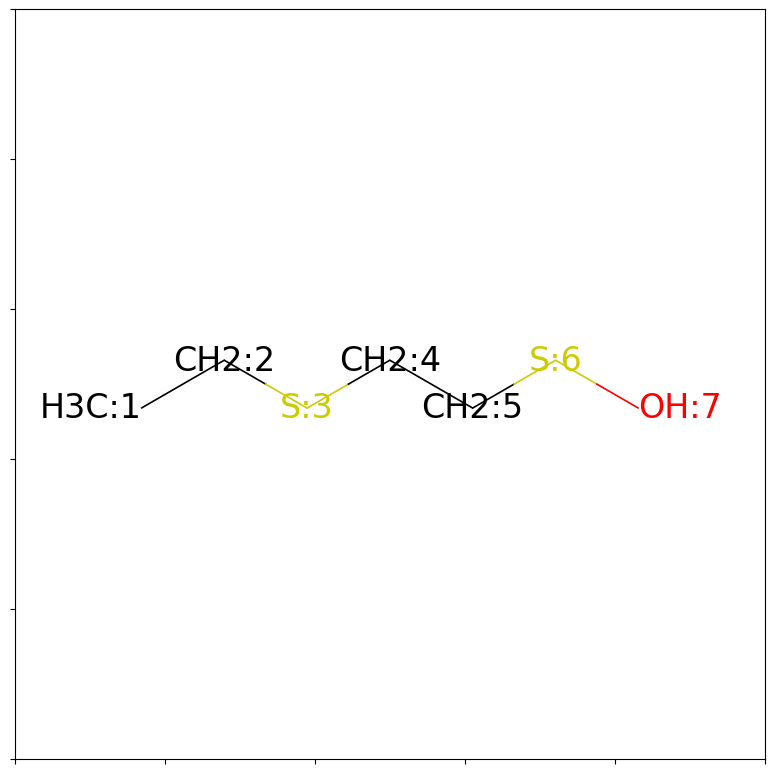

In [115]:
# Try challenge problem
smi1 = '[CH3:1][CH2:2][S:3][OH:4]'
smi2 = '[CH3:1][CH2:2][S:3][CH2:4][CH2:5][S:6][OH:7]'
mol1 = Chem.MolFromSmiles(smi1)
mol2 = Chem.MolFromSmiles(smi2)
mols = [mol1, mol2]

for elt in mols:
    img = Draw.MolToMPL(elt)
    img.show()

In [116]:
# Set isotope to atomic num for all atoms
for this_mol in mols:
    for elt in this_mol.GetAtoms():
        elt.SetIsotope(elt.GetAtomicNum())

In [117]:
# Set isotopes differently for rxn ctr atoms
# just get beyond periodic table
m1a1 = mol1.GetAtomWithIdx(0)
m1a2 = mol1.GetAtomWithIdx(1)
m2a1 = mol2.GetAtomWithIdx(0)
m2a2 = mol2.GetAtomWithIdx(1)
atoms = [m1a1, m1a2, m2a1, m2a2]
for elt in atoms:
    elt.SetIsotope(elt.GetAtomMapNum() * elt.GetAtomicNum() * 99)



In [118]:
Chem.MolToSmarts(mol1), Chem.MolToSmarts(mol2)

('[594#6H3:1]-[1188#6H2:2]-[16#16:3]-[8#8H:4]',
 '[594#6H3:1]-[1188#6H2:2]-[16#16:3]-[6#6H2:4]-[6#6H2:5]-[16#16:6]-[8#8H:7]')

# common atoms / bonds: 4 / 3
[#6]-[#6]-[#16]-[#8]


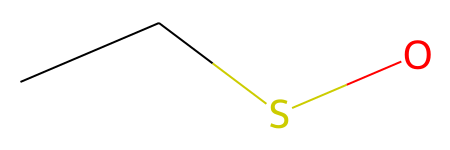

In [119]:
# W/o enforcing rxn center
pred_ss = '[594#6H3:1]-[1188#6H2:2]'
res = rdFMCS.FindMCS(mols, seedSmarts=pred_ss, atomCompare=rdFMCS.AtomCompare.CompareElements)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
print(res.smartsString)
Chem.MolFromSmarts(res.smartsString)

# common atoms / bonds: 3 / 2
[594*]-[1188*]-[16*]


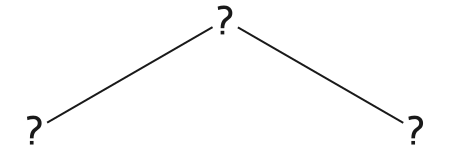

In [120]:
# W/ enforcing rxn center

pred_ss = '[594#6H3:1]-[1188#6H2:2]'
res = rdFMCS.FindMCS(mols, seedSmarts=pred_ss, atomCompare=rdFMCS.AtomCompare.CompareIsotopes)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
print(res.smartsString)
Chem.MolFromSmarts(res.smartsString)

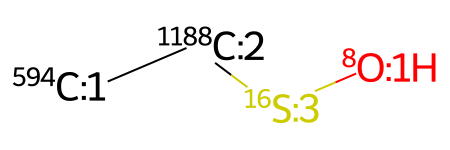

In [125]:
foo = mol1.GetAtomWithIdx(3)
foo.SetAtomMapNum(1)

mol1

In [129]:
foo = '[C:1]-[C:2]=[C:3]'
bar = '[C:4]=[C:8]-[C:6]'
print(Chem.MolToSmarts(Chem.MolFromSmarts(foo)))
print(Chem.MolToSmarts(Chem.MolFromSmarts(bar)))

[C:1]-[C:2]=[C:3]
[C:4]=[C:8]-[C:6]


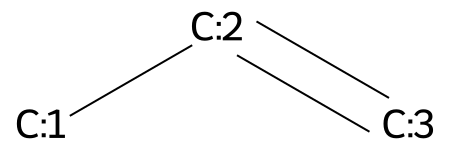

In [130]:
Chem.MolFromSmarts(foo)

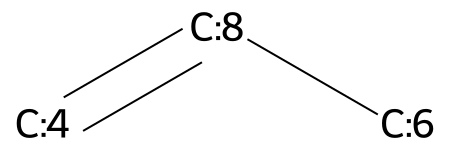

In [131]:
Chem.MolFromSmarts(bar)